In [1]:
#Description: 
#  This notebook uses LIME to make post-hoc explanations of classifications
#  LIME stands for local interpretable model-agnostic explanations 
#  see https://github.com/marcotcr/lime
#      https://arxiv.org/abs/1602.04938
#
#  Another alternative is to use SHAP (SHapley Additive exPlanations): https://github.com/slundberg/shap
#

# Setup

In [2]:
#imports

import numpy as np
from keras.models import load_model

from tensorflow.keras.preprocessing import image

import lime
from lime import lime_image

import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries



2023-06-18 09:18:48.098511: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
#suppress warnings
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)


# Load Model and Parameters

In [4]:
# Load the Keras model
model = load_model('saved_myXception_model.h5')

2023-06-18 09:18:52.669058: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-18 09:18:52.671080: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [5]:
# Set input image size used by model
image_size = (180, 180)  

# Form Preprocessing Function

In [6]:
preprocess = lambda x:x #identity function since no preprocessing -- here for consistency with other models

# Form Inverse-processing Function

In [7]:
inv_preprocess = lambda x:x.astype("uint8") #does not preprocess image, so just make sure it is unit8

# Load Data & Examine

In [8]:
n=56
image_path = "/home/dm/ml_n_code/sandbox/cats_vs_dogs/data/train/Cat/" + str(n)+".jpg"


In [9]:
img_raw = image.load_img(image_path, target_size=image_size)
x = image.img_to_array(img_raw)
x = np.expand_dims(x, axis=0)
x = preprocess(x) #identify function since model does not preprocess

out = []
out.append(x)
data=np.vstack(out)

Text(0.5, 1.0, 'Original')

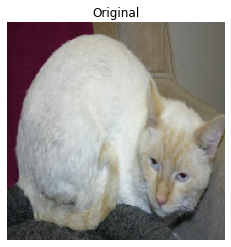

In [10]:
#check input image
plt.imshow(img_raw)
plt.axis("off")
plt.title("Original")


Text(0.5, 1.0, 'Inverse-Preprocessing Check')

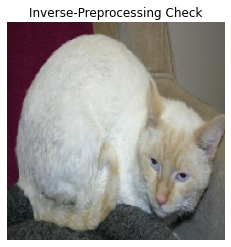

In [11]:
#spot-check inverse-preprocessing function
plt.imshow(inv_preprocess(data[0]))
plt.axis("off")
plt.title("Inverse-Preprocessing Check")


# Find Prediction(s)

In [12]:
preds = model.predict(data)
for x in preds:
    score = float(x)
    print(f"This image is {100 * (1 - score):.2f}% cat and {100 * score:.2f}% dog.")


2023-06-18 09:18:54.693600: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] remapper failed: INVALID_ARGUMENT: Mutation::Apply error: fanout 'model/activation_5/Relu' exist for missing node 'model/add/add'.
2023-06-18 09:18:54.734602: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] remapper failed: INVALID_ARGUMENT: Mutation::Apply error: fanout 'model/activation_5/Relu' exist for missing node 'model/add/add'.


1/1 [==============================] - 1s 691ms/step
This image is 89.24% cat and 10.76% dog.


# Find Explanations

In [13]:
# Create the LIME explainer
explainer = lime_image.LimeImageExplainer()

In [14]:
# Explain the prediction
explanation = explainer.explain_instance(
        data[0].astype('double'),
        model.predict,
        top_labels=2,  # Set the number of top labels to include in the explanation
        hide_color=0, 
        num_samples=1000,  # Set the number of samples to use in LIME
    )


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 1s 977ms/step


Text(0.5, 1.0, 'Explanation')

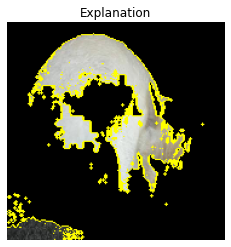

In [15]:
#see the explanation for the top class -- just show positive parts
temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0], 
    positive_only=True, 
    num_features=5, 
    hide_rest=True
)
plt.imshow(mark_boundaries(inv_preprocess(temp), mask))
plt.axis("off")
plt.title("Explanation")


Text(0.5, 1.0, 'Explanation Mask')

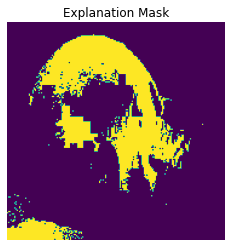

In [16]:
#show region label mask
plt.figure()
plt.imshow(mask)
plt.axis("off")
plt.title('Explanation Mask')

Text(0.5, 1.0, 'Explanation with Rest of Image')

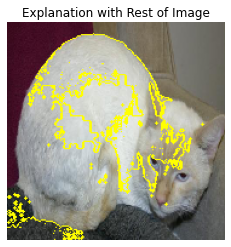

In [17]:
#see the explanation for the top class -- with the rest of the image present
temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0], 
    positive_only=True, 
    num_features=5, 
    hide_rest=False
)
plt.imshow(mark_boundaries(inv_preprocess(temp), mask))
plt.axis("off")
plt.title('Explanation with Rest of Image')

Text(0.5, 1.0, 'Explanation Pros (Green) and Cons (Red)')

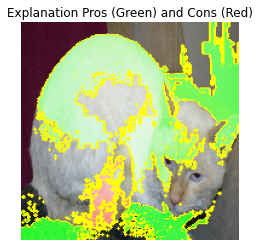

In [18]:
#see the 'pros and cons' (pros contributing to class call in green, cons in red)
temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0], 
    positive_only=False, 
    num_features=10, 
    hide_rest=False)
plt.imshow(mark_boundaries(inv_preprocess(temp), mask))
plt.axis("off")
plt.title('Explanation Pros (Green) and Cons (Red)')

Text(0.5, 1.0, 'Explanation Heatmap')

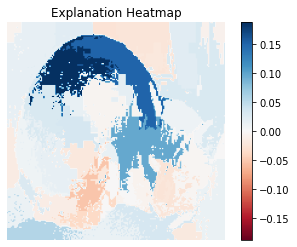

In [19]:
#explanation weights heatmap visualization

#Select the same class explained on the figures above.
ind =  explanation.top_labels[0]

#Map each explanation weight to the corresponding superpixel
dict_heatmap = dict(explanation.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 

#Plot. The visualization makes more sense if a symmetrical colorbar is used.
plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
plt.colorbar()
plt.axis("off")
plt.title('Explanation Heatmap')

In [20]:
explanation.top_labels[0] #for result, cat = 0, dog = 1

0